# Verification of Elastic wave equation implementation on a staggered grid using the method of manufactured solutions.
This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (4000., 4000.)
shape = (301, 301)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

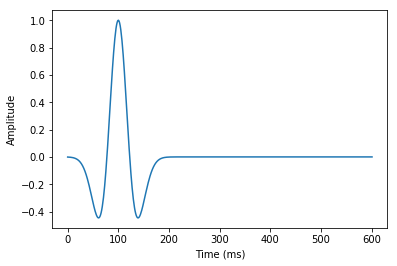

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 600.
dt = (10. / np.sqrt(2.)) / 6.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
from examples.seismic import Model
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1*self.spacing[0]

In [5]:
# Now we create the velocity and pressure fields


model = ModelBench(vp=1.5, origin=(0., 0.), spacing=(.5, .5), shape=(801, 801), nbpml=40, space_order=0, dtype=np.float64)

so = 2 # space order
vx  = TimeFunction(name='vx' , grid=grid, staggered = x,    space_order=so)
vz  = TimeFunction(name='vz' , grid=grid, staggered = z,    space_order=so)
txx = TimeFunction(name='txx', grid=grid, staggered = NODE, space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered = NODE, space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so)

In [6]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3.

# The source injection term
src_xx = src.inject(field=txx.forward, expr=src)
src_zz = src.inject(field=tzz.forward, expr=src)

#c1 = 9.0/8.0;
#c2 = -1.0/24.0;

# Thorbecke's parameter notation
cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1/density

mu = cs2*ro
l = (cp2*ro - 2*mu)


# Analytical solution definition

In [7]:
# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op()



Operator `Kernel` run in 0.12 s


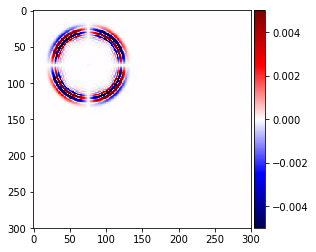

In [8]:
# Let's see what we got....
#plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

Operator `Kernel` run in 0.71 s


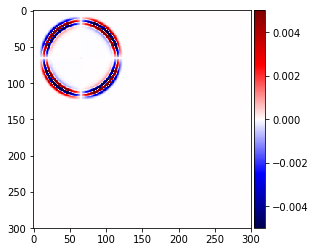

In [9]:
# Now that looks pretty! But let's do it again with a higher space order...
so  = 12
vx  = TimeFunction(name='vx' , grid=grid, staggered=x     , space_order=so)
vz  = TimeFunction(name='vz' , grid=grid, staggered=z     , space_order=so)
txx = TimeFunction(name='txx', grid=grid, staggered=NODE  , space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE  , space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op()

vmin= -.5*1e-2
vmax=  .5*1e-2

#plot_image(vx.data[0] , vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(vz.data[0] , vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(txx.data[0], vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(tzz.data[0], vmin = vmin, vmax = vmax, cmap="seismic")
plot_image(txz.data[0], vmin = vmin, vmax = vmax, cmap="seismic")

# Corresponding source

In [10]:
import sympy
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc
u, v, w, c = sympy.symbols('u v w c')
sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)

source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})


# Elastic wave equation

In [11]:

    so = 0
    vx  = TimeFunction(name='vx',  grid=model.grid, staggered=x,      space_order=16, time_order=2)
    vz  = TimeFunction(name='vz',  grid=model.grid, staggered=z,      space_order=16, time_order=2)
    txx = TimeFunction(name='txx', grid=model.grid, staggered=NODE,   space_order=16, time_order=2)
    tzz = TimeFunction(name='tzz', grid=model.grid, staggered=NODE,   space_order=16, time_order=2)
    txz = TimeFunction(name='txz', grid=model.grid, staggered=(x, z), space_order=16, time_order=2)
    
    # Wave equation
    vx_true  = TimeFunction(name="vx_true" , grid=model.grid, staggered=x,      space_order=so, time_order=2)
    vz_true  = TimeFunction(name='vz_true' , grid=model.grid, staggered=z,      space_order=so, time_order=2)
    txx_true = TimeFunction(name='txx_true', grid=model.grid, staggered=NODE,   space_order=so, time_order=2)
    tzz_true = TimeFunction(name='tzz_true', grid=model.grid, staggered=NODE,   space_order=so, time_order=2)
    txz_true = TimeFunction(name='txz_true', grid=model.grid, staggered=(x, z), space_order=so, time_order=2)
    
    
    vx_src  = TimeFunction(name="vx_src" , grid=model.grid, staggered=x,     space_order=so, time_order=0)
    vz_src  = TimeFunction(name='vz_src' , grid=model.grid, staggered=z,      space_order=so, time_order=0)
    txx_src = TimeFunction(name='txx_src', grid=model.grid, staggered=NODE,   space_order=so, time_order=0)
    tzz_src = TimeFunction(name='tzz_src', grid=model.grid, staggered=NODE,   space_order=so, time_order=0)
    txz_src = TimeFunction(name='txz_src', grid=model.grid, staggered=(x, z), space_order=so, time_order=0)
    
    wave_eq = Eq(vx.forward, 2 * vx - vx.backward + t.spacing**2/1 * (vx.laplace + src))

In [12]:




#import sympy
#from sympy import cos, sin, exp, pprint, sqrt, sin, sinc
#def mms_sol(model):
#    u, v, w, c = sympy.symbols('u v w c')
#     sol = 1e2*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)
#    sol = (1e4*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
#           1e3*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
#           5000*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
#           1e4*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
#           5*1e3*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
#    source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
#    x, z = model.grid.dimensions
#    t = model.grid.time_dim
#    
#    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    
#    return sol, source

In [13]:
#import sympy
#from sympy import cos, sin, exp, pprint, sqrt, sin, sinc

#def mms_sol_elastic(model):
#    u, v, w, c = sympy.symbols('u v w c')
#     sol = 1e2*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)
#    sol = (1e4*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
#           1e3*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
#           5000*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
#           1e4*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
#           5*1e3*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
#    source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
#    x, z = model.grid.dimensions
#    t = model.grid.time_dim
#    
#    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
#    
#    return sol, source

In [14]:
# def get_solution(size, space_order):
#     clear_cache()
    
    
    
    
    
#     # Model
#     v = 1.5 * np.ones((size, size))
#     v[:, 75:] = 2.5
#     v[:, 125:] = 3.0
    
#     model = ModelBench(vp=v, origin=(0., 0.), spacing=(1., 1.), shape=(size, size),
#                        nbpml=0, space_order=0, dtype=np.float64)
    
#     x, z = model.grid.dimensions
#     t = model.grid.time_dim
#     # Grid
#     h = 1./(size - 1)
#     dt = 1e-7
#     nt = 350
#     # Wave equation
#     u = TimeFunction(name="u", grid=model.grid, space_order=space_order, time_order=2, save=nt)
#     u_true = TimeFunction(name="utrue", grid=model.grid, space_order=space_order, time_order=0, save=nt)
#     src = TimeFunction(name="src", grid=model.grid, space_order=space_order, time_order=0, save=nt)

#     sol, source = mms_sol(model)
    
#     wave_eq = Eq(u.forward, 2 * u - u.backward + t.spacing**2/model.m * (u.laplace + src))
#     true_eqq = Eq(u_true, sol)

#     src_eq = Eq(src, source)
    
#     u_1 = Eq(u.subs(t, 1), sol.subs(t, 1))
#     configuration["log-level"] = "ERROR"
#     op = Operator([u_1, true_eqq, src_eq, wave_eq], subs=({t.spacing: dt, x.spacing:h, z.spacing:h}))
#     op.apply()

#     error = np.linalg.norm(u.data[(nt-3), :, :].reshape(-1) -
#                            u_true.data[(nt-3), :, :].reshape(-1), 2)*h
# #     import matplotlib.pyplot as plt
# #     plt.figure()
# #     plt.subplot(131)
# #     plt.imshow(u.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
# #     plt.subplot(132)
# #     plt.imshow(u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
# #     plt.subplot(133)
# #     plt.imshow(u.data[(nt-3), :, :] - u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
# #     plt.show()
#     print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))
#     return error


In [15]:
import sympy
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc

def get_solution_elastic(size, space_order):
    clear_cache()
    
    # Grid
    h = 1./(size - 1)
    #dt = 1e-7
    #nt = 86
    # Initial grid: 1km x 1km, with spacing 100m
    extent = (2000., 2000.)
    shape = (size, size)
    x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
    z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
    grid = Grid(extent=extent, shape=shape, dimensions=(x, z))
    
    # Model
    # Timestep size from Eq. 7 with V_p=6000. and dx=100
    t0, tn = 0., 500.
    dt = (10. / np.sqrt(2.)) / 18.

    time_range = TimeAxis(start=t0, stop=tn, step=dt)
    src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
    src.coordinates.data[:] = [1000., 1000.]
    
    nt = 1274;   # FIX ME
    
    # Now we create the velocity and pressure fields
    so = space_order
    vx  = TimeFunction(name='vx',  grid=grid, staggered=x,      space_order=so, time_order=1, save=nt)
    vz  = TimeFunction(name='vz',  grid=grid, staggered=z,      space_order=so, time_order=1, save=nt)
    txx = TimeFunction(name='txx', grid=grid, staggered=NODE,   space_order=so, time_order=1, save=nt)
    tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE,   space_order=so, time_order=1, save=nt)
    txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so, time_order=1, save=nt)
    
    # Wave equation
    vx_true  = TimeFunction(name="vx_true" , grid=grid, staggered=x,      space_order=so, time_order=0, save=nt)
    vz_true  = TimeFunction(name='vz_true' , grid=grid, staggered=z,      space_order=so, time_order=0, save=nt)
    txx_true = TimeFunction(name='txx_true', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    tzz_true = TimeFunction(name='tzz_true', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    txz_true = TimeFunction(name='txz_true', grid=grid, staggered=(x, z), space_order=so, time_order=0, save=nt)
    
    
    vx_src  = TimeFunction(name="vx_src" , grid=grid, staggered=x,     space_order=so, time_order=0, save=nt)
    vz_src  = TimeFunction(name='vz_src' , grid=grid, staggered=z,      space_order=so, time_order=0, save=nt)
    txx_src = TimeFunction(name='txx_src', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    tzz_src = TimeFunction(name='tzz_src', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    txz_src = TimeFunction(name='txz_src', grid=grid, staggered=(x, z), space_order=so, time_order=0, save=nt)
    
    
    
    ###################input = ###########################################################
    u, v, w, c = sympy.symbols('vx vz txx txz')
    #sol = 1*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)* sin(8*np.pi*u)
    sol = (10*sin(6*np.pi*vx) * exp(-(vx - .5)**2/.015 - (vx-.5)**2/.015) +
           10*sin(4*np.pi*vz) *exp(-(vz - .45)**2/.0025 - (vz-.65)**2/.0025)-
           50*sin(8*np.pi*vx) *exp(-(vz - .65)**2/.0025 - (txx-.45)**2/.0015)+
           10*sin(6*np.pi*tzz) * exp(-(vz - .45)**2/.0015 - (txx-.45)**2/.0025)-
           50*sin(6*np.pi*txz) * exp(-(vz - .65)**2/.0027 - (txx-.65)**2/.0021))
    
    source_vx  =  model.m*sol.diff(vz, vz) - sol.diff(txx, txx) - sol.diff(vx, vx)
    source_vz  =  model.m*sol.diff(vx, vx) - sol.diff(vz, vz) - sol.diff(txx, tzz)
    source_txx =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    source_tzz =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    source_txz =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    
    x, z = model.grid.dimensions
    t = model.grid.time_dim
    
    #print(sol)
    #sol       = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    #print(sol)
    #source_vx = source_vx.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    #source_vz = source_vz.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    #################################################################################
    
    
    
    
    # Now let's try and create the staggered updates
    t = grid.stepping_dim
    time = grid.time_dim

    # We need some initial conditions
    V_p = 4.0
    V_s = 1.0
    density = 3.

    # The source injection term
    src_xx = src.inject(field=txx.forward, expr=src)
    src_zz = src.inject(field=tzz.forward, expr=src)

    #c1 = 9.0/8.0;
    #c2 = -1.0/24.0;

    # Thorbecke's parameter notation
    cp2 = V_p*V_p
    cs2 = V_s*V_s
    ro = 1/density

    mu = cs2*ro
    l = (cp2*ro - 2*mu)
    
    # fdelmodc reference implementation
    u_vx  = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
    u_vz  = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
    u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
    u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
    u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))
    
 
    op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)
    
    vx.data[:] = 0.
    vz.data[:] = 0.
    txx.data[:] = 0.
    tzz.data[:] = 0.
    txz.data[:] = 0.
    
    vx_true.data[:] = 0.
    vz_true.data[:] = 0.
    txx_true.data[:] = 0.
    tzz_true.data[:] = 0.
    txz_true.data[:] = 0.
    
    vx_src.data[:] = 0.
    vz_src.data[:] = 0.
    txx_src.data[:] = 0.
    tzz_src.data[:] = 0.
    txz_src.data[:] = 0.

    op()

          


    
    
    sum_source = source_vx+source_vz+source_txx+source_tzz+source_txz
    
    #wave_eq = u_all + sum_source
    wave_eq = u_vx
    #print(wave_eq)
    #Eq(vx.forward, 2* vx)
    
    true_eqq_vx = Eq(vx_true, sol)
    true_eqq_vz = Eq(vz_true, sol)
    true_eqq_txx = Eq(txx_true, sol)

    true_eqq_txz = Eq(txz_true, sol)

    true_eqq_tzz = Eq(tzz_true, sol)

    #print(true_eqq)

    #src_eq = Eq(vx_src + vz_src + txz_src + tzz_src + txz_src, sum_source)
    src_eq_vx = Eq(vx_src,source_vx)
    src_eq_vz = Eq(vz_src,source_vz)
    src_eq_txx = Eq(txx_src,source_txx)
    src_eq_txz = Eq(txz_src,source_txz)
    src_eq_tzz = Eq(tzz_src,source_tzz)
    
    #print(src_eq)

    #print(vx)
    #u_1 = Eq(vx.subs(t, 1), sol.subs(t, 1))
    #print(u_1)
    
    configuration["log-level"] = "ERROR"
    #h = .00125

    #op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz, subs=({t.spacing: dt, x.spacing:h, z.spacing:h}))
    #op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)
    #op = Operator([u_txz] + src_xx + src_zz)
    #op = Operator([u_1, true_eqq, src_eq])
    #op = Operator([u_1, true_eqq, src_eq, wave_eq])
    op = Operator([ true_eqq_vx,true_eqq_vz,true_eqq_txx, src_eq_vx,src_eq_vz, u_vx, u_vz,u_txx,u_txz,u_tzz] + src_xx + src_zz,
                  subs=({t.spacing: dt, x.spacing:h, z.spacing:h}))
    op.apply()

    error1 = np.linalg.norm(vx.data[(nt-3), :, :].reshape(-1) -
                            vx_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error2 = np.linalg.norm(vz.data[(nt-3), :, :].reshape(-1) -
                            vz_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error3 = np.linalg.norm(txx.data[(nt-3), :, :].reshape(-1) -
                            txx_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error4 = np.linalg.norm(txz.data[(nt-3), :, :].reshape(-1) -
                           txz_true.data[(nt-3), :, :].reshape(-1), 2)*h
    error5 = np.linalg.norm(tzz.data[(nt-3), :, :].reshape(-1) -
                           tzz_true.data[(nt-3), :, :].reshape(-1), 2)*h
    
    error = (error1 + error2 + error3 + error4 +error5) / 5
    #error = (error1 + error2 + error3 ) / 3
    #print("for h = %f and dt= %2.2e ms error1 is %2.4e error2 is %2.4e error3 is %2.4e" % (h, dt, error1,error2,error3))
    print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))

    
    
    
#  import matplotlib.pyplot as plt
#     plt.figure()
#     plt.subplot(131)
#     plt.imshow(u.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(132)
#     plt.imshow(u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(133)
#     plt.imshow(u.data[(nt-3), :, :] - u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.show()



    return error

# MMS

In [16]:
size = [26, 51, 101, 201]

t = 2
so = [2,6,10]
error = np.zeros((len(size), len(so)))
hh = [0.04, 0.02, 0.01, 0.005]

#hh = [0.04, 0.02, 0.01, 0.005, 0.001]
#hh = [1, .5, .25, .125]
# hh = [4*h for h in hh]
for i, s in enumerate(size):
    for j, sso in enumerate(so):
        error[i, j] = get_solution_elastic(s, sso)

Operator `Kernel` run in 0.01 s


for h = 0.040000 and dt= 3.93e-01 ms error is 3.9709e-01
for h = 0.040000 and dt= 3.93e-01 ms error is 4.2597e-01
for h = 0.040000 and dt= 3.93e-01 ms error is 4.9988e-01
for h = 0.020000 and dt= 3.93e-01 ms error is 7.5940e-01
for h = 0.020000 and dt= 3.93e-01 ms error is 7.8742e-01
for h = 0.020000 and dt= 3.93e-01 ms error is 7.5095e-01
for h = 0.010000 and dt= 3.93e-01 ms error is 1.3759e-01
for h = 0.010000 and dt= 3.93e-01 ms error is 1.2380e-01
for h = 0.010000 and dt= 3.93e-01 ms error is 1.2317e-01
for h = 0.005000 and dt= 3.93e-01 ms error is 3.1392e-02
for h = 0.005000 and dt= 3.93e-01 ms error is 3.0715e-02
for h = 0.005000 and dt= 3.93e-01 ms error is 3.0712e-02


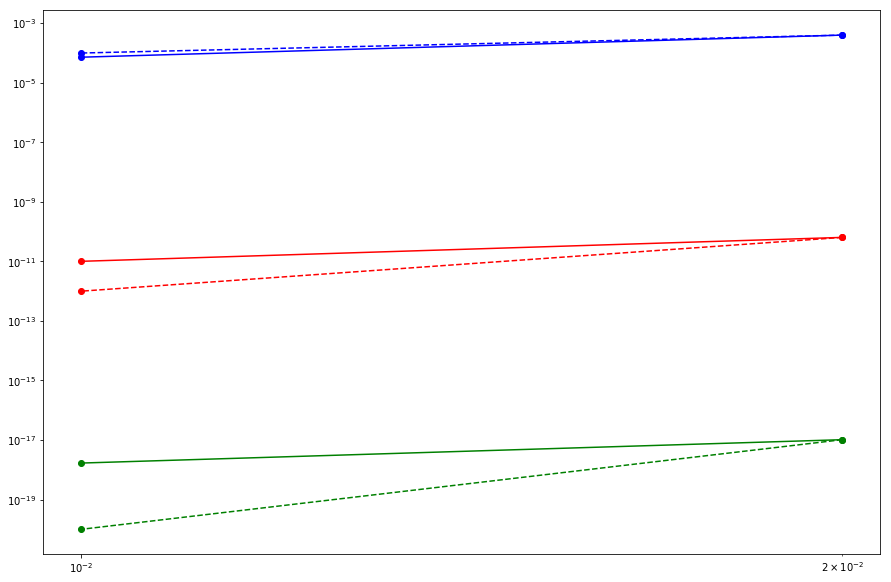

In [17]:
import matplotlib.pyplot as plt
col = ['-ob', '-or', '-og', '-ok', '-oc']
col_2 = ['--ob', '--or', '--og', '--ok', '--oc']
hh = [0.04, 0.02, 0.01, 0.005]
#hh = [1, .5, .25, .125]
#hh = [4*h for h in hh]
plt.figure(figsize=(15, 10))
for j, sso in enumerate(so):
    plt.loglog(hh[1:3], hh[1]**so[j]*error[1:3, j]/error[1, j], col[j])
    plt.loglog(hh[1:3], [h**so[j] for h in hh][1:3], col_2[j])

    #plt.loglog(hh[1:3], error[:, 3])
    #plt.loglog(hh[1:3], [h**so[3] for h in hh])

Text(0.5, 0, 'Space order')

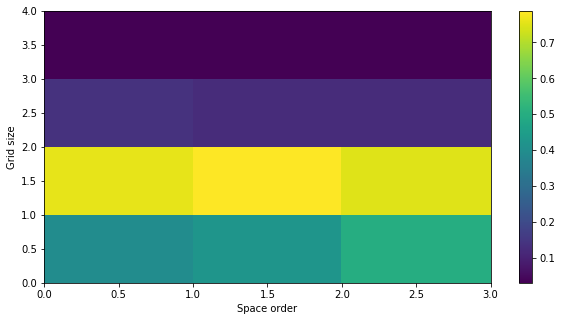

In [18]:
fig = plt.figure(figsize=(10, 5))
im = plt.pcolormesh(error)
fig.colorbar(im)
plt.ylabel('Grid size')
plt.ylabel('Grid size')
plt.ylabel('Grid size')

plt.xlabel('Space order')